Reference:
https://towardsdatascience.com/introduction-to-web-scraping-with-beautifulsoup-e87a06c2b857

https://medium.com/dunder-data/create-a-bar-chart-race-animation-in-python-with-matplotlib-477ed1590096

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
import seaborn as sns
from bs4 import BeautifulSoup, SoupStrainer
import urllib.request
import re
from IPython.display import HTML

import warnings
warnings.filterwarnings("ignore")

C:\Users\Kooritsuki\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#set user agent as browser to bypass bot detection
user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '\
'AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.149 '\
'Safari/537.36'

#set URL of target site and open page
url = "https://carsalesbase.com/car-sales-us-home-main/car-sales-by-brand-us/"

try :
    request = urllib.request.Request(url)
    request.add_header('User-Agent', user_agent)
    response = urllib.request.urlopen(request)
except :
    print ("Cannot open webpage")

In [3]:
# retrive all links from webpage
links = []
for link in BeautifulSoup(response, "html.parser", parse_only = SoupStrainer("a")) :
    if link.has_attr("href") :
        links.append(link["href"])
        
links = pd.Series(links)

In [4]:
#filter out only the links for US sales by manifacturer
us_links = links[links.str.contains("https://carsalesbase.com/us-")]
us_links = us_links.loc[:152]
us_links.reset_index(drop = True, inplace = True)

In [5]:
car_sales = pd.DataFrame()
brand_sales = pd.DataFrame()

#scrape annual sales data from each link
for link in us_links:
    name = link.split(sep = "/")[-2].split(sep = "us-")[-1].capitalize() #get manufacturer name
    try :
        request = urllib.request.Request(link)
        request.add_header("User-Agent", user_agent)
        response = urllib.request.urlopen(request)
    except :
        print("Cannot open webpage for :", name)
    else :
        #scrape tables only
        soup = BeautifulSoup(response, "html.parser", parse_only = SoupStrainer("tr"))
        #get row ids
        rows = []
        for row in soup :
            if row.has_attr("id") :
                rows.append(row["id"])
        #get table and row numbers
        ids = pd.Series(rows).str.split(pat = "_", expand = True)
        table_num = ids.iloc[:, 1].unique()
        if (len(table_num) > 1) :
            table_num = table_num[1]
        else :
            table_num = table_num[0]
        row_id = ids[ids[1] == table_num].iloc[:, 3]
        #get year and sales data
        year = []
        sales = []
        for i in row_id :
            table_id = re.compile("table_" + table_num + "_row_" + i + "$")
            table = soup.find_all("tr", id = table_id)
            for tds in table :
                result = tds.text.split("\n")
                year.append(int(result[1]))
                sales.append(float(result[2].replace(",", "")))
        brand_sales = pd.DataFrame(columns = ["year", name])
        brand_sales["year"] = year
        brand_sales[name] = sales
        brand_sales = brand_sales.drop_duplicates("year", keep = "last")
        brand_sales = brand_sales.set_index("year", drop = True)
        car_sales = pd.concat([car_sales, brand_sales], axis = 1)
        # print("Scrapping completed for:", name)

In [6]:
car_sales = car_sales.sort_index()
car_sales.index = car_sales.index.rename("Year")
car_sales.columns = ['Acura', 'Alfa-Romeo', 'Aston-Martin', 'Audi', 'Bentley', 'BMW',
       'Buick', 'Cadillac', 'Chevrolet', 'Chrysler', 'Daewoo', 'Daihatsu',
       'Dodge', 'Ferrari', 'Fiat', 'Ford', 'Genesis', 'GMC', 'Honda', 'Hummer',
       'Hyundai', 'Infiniti', 'Isuzu', 'Jaguar', 'Jeep', 'Kia', 'Lamborghini',
       'Lancia', 'Land-rover', 'Lexus', 'Lincoln', 'Lotus', 'Maserati',
       'Maybach', 'Mazda', 'Mclaren', 'Mercedes-Benz', 'Mercury', 'MG', 'Mini',
       'Mitsubishi', 'Oldsmobile', 'Peugeot', 'Plymouth', 'Pontiac',
       'Range-Rover', 'Ram', 'Rolls-Royce', 'Saab', 'Saturn', 'Scion', 'Smart',
       'Sterling', 'Subaru', 'Suzuki', 'Tesla', 'Toyota', 'Triumph',
       'Volkswagen', 'Volvo', 'Yugo']
car_sales

,Acura,Alfa-Romeo,Aston-Martin,Audi,Bentley,BMW,Buick,Cadillac,Chevrolet,Chrysler,...,Smart,Sterling,Subaru,Suzuki,Tesla,Toyota,Triumph,Volkswagen,Volvo,Yugo
Year,,,,,,,,,,,,,,,,,,,,,
1948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,177165.0,663.0,1020.0,202202.0,2686.0,346023.0,223055.0,175267.0,2125347.0,324846.0,...,7484.0,NaN,582675.0,NaN,25416.0,2098545.0,NaN,349440.0,70047.0,NaN
2016,161360.0,528.0,NaN,210213.0,2581.0,313174.0,229631.0,170006.0,2096508.0,239492.0,...,6211.0,NaN,615132.0,NaN,47644.0,2106332.0,NaN,322948.0,82593.0,NaN
2017,154602.0,12031.0,NaN,226511.0,2405.0,305685.0,219231.0,156440.0,2065879.0,188545.0,...,3071.0,NaN,647956.0,NaN,50145.0,2129177.0,NaN,339676.0,81507.0,NaN


In [7]:
#export data
car_sales.to_csv("data/car_sales.csv", index = True)

In [8]:
# #import data
# car_sales = pd.read_csv("data/car_sales.csv", index_col = "Year")
# car_sales.dtypes

Acura           float64
Alfa-Romeo      float64
Aston-Martin    float64
Audi            float64
Bentley         float64
                 ...   
Toyota          float64
Triumph         float64
Volkswagen      float64
Volvo           float64
Yugo            float64
Length: 61, dtype: object

In [9]:
#get cummulative sum for car sales over the years
car_sales_cumm = car_sales.cumsum(axis = 0)

#fill all NAs with 0
car_sales_cumm = car_sales_cumm.fillna(method = "ffill")

In [10]:
# create 5 steps between each row
car_sales_cumm = car_sales_cumm.reset_index()
car_sales_cumm.index = car_sales_cumm.index * 5

#create empty rows to fit between the new index
last_idx = car_sales_cumm.index[-1] + 1
car_sales_cumm = car_sales_cumm.reindex(range(last_idx))

#fill forward the year column
car_sales_cumm["Year"] = car_sales_cumm["Year"].fillna(method = "ffill")

#set year as index
car_sales_cumm = car_sales_cumm.set_index("Year")

In [11]:
#create ranking dataframe
car_sales_rank = car_sales_cumm.rank(method = "first", axis = 1)
car_sales_rank = car_sales_rank.interpolate()

#fill NAs by linear interpolate forar missing values
car_sales_cumm = car_sales_cumm.interpolate()

<IPython.core.display.Javascript object>


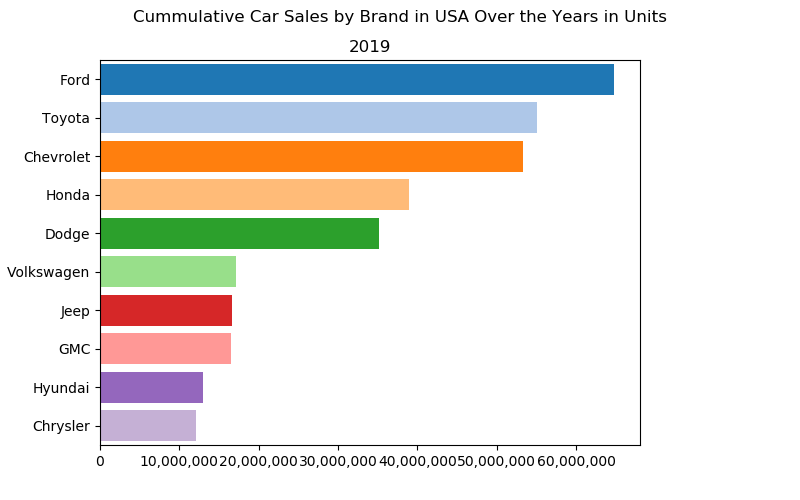

In [12]:
%matplotlib notebook
from matplotlib.ticker import StrMethodFormatter

#plot animated graph

fig, ax = plt.subplots(figsize = (8, 5))
fig.suptitle("Cummulative Car Sales by Brand in USA Over the Years in Units")
fig.subplots_adjust(right = .8)

colors = plt.cm.tab20(range(10))

def init() :
    ax.clear()

def animate(i) :
    for bar in ax.containers:
        bar.remove()
    top = car_sales_rank.iloc[i].sort_values(ascending = False).head(10).index.tolist()
    s = car_sales_cumm.iloc[i][top]
    r = car_sales_rank.iloc[i][top]
    ax.barh(y = r, width = s, tick_label = s.index, color = colors)
    max_rank = max(r) + 0.5
    min_rank = min(r) - 0.5
    ax.set_ylim(ymin = min_rank, ymax = max_rank)
    ax.xaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
    plt.title(int(s.name))

ani = animation.FuncAnimation(fig = fig,
                              func = animate,
                              init_func = init,
                              frames = len(car_sales_cumm),
                              interval = 100,
                              repeat = False
                              )

plt.show()

In [13]:
#set up writer parameter
writer_gif = animation.PillowWriter(fps = 60)

#save the graph in gif
ani.save("us_car_sales.gif", writer = writer_gif)